# Regresiones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Resultado del mes anterior

In [2]:
imacec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20Imacec.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imacec.columns = ['imacec']
imacec.tail()

,imacec
Fecha,
2021-09-01,14.753843
2021-10-01,14.951209
2021-11-01,14.265823
2021-12-01,10.118327
2022-01-01,8.962461


In [3]:
# ACTUALIZAR nombre de documento
prediccion = pd.read_csv('pred_2022_02.csv', index_col=0)
prediccion

,prediccion
percepcion,
IPECO,3.917636
IPEC,10.434099
ICE,5.116419
IMCE,7.262238
Consumidores,6.914423
Empresarios,6.937855
Todos,5.203622


In [4]:
prediccion['imacec'] = imacec['imacec'][-1]
prediccion['abs-error'] = np.abs(prediccion['prediccion'] - prediccion['imacec'])
prediccion.sort_values('abs-error').round(2)

,prediccion,imacec,abs-error
percepcion,,,
IPEC,10.43,8.96,1.47
IMCE,7.26,8.96,1.70
Empresarios,6.94,8.96,2.02
Consumidores,6.91,8.96,2.05
Todos,5.20,8.96,3.76
ICE,5.12,8.96,3.85
IPECO,3.92,8.96,5.04


In [5]:
prediccion = prediccion.sort_values('abs-error')
prediccion['ranking'] = np.arange(1,8,1)

In [6]:
# ACTUALIZAR nombre de documento
prediccion.to_csv('res_2022_02.csv')
prediccion.round(2)

,prediccion,imacec,abs-error,ranking
percepcion,,,,
IPEC,10.43,8.96,1.47,1
IMCE,7.26,8.96,1.70,2
Empresarios,6.94,8.96,2.02,3
Consumidores,6.91,8.96,2.05,4
Todos,5.20,8.96,3.76,5
ICE,5.12,8.96,3.85,6
IPECO,3.92,8.96,5.04,7


In [7]:
# ACTUALIZAR nombre (segunda fila)
ranking_actual = prediccion[['ranking']]
ranking_actual.columns = ['R-2022-02']

ranking_acumulado = pd.read_csv('ranking_acumulado.csv', index_col='percepcion')
ranking_acumulado = pd.concat([ranking_acumulado, ranking_actual], axis=1)
ranking_acumulado.to_csv('ranking_acumulado.csv')
ranking_acumulado

,R-2011-05,R-2021-06,R-2021-07,R-2021-08,R-2021-09,R-2021-10,R-2021-11,R-2021-12,R-2022-01,R-2022-02
percepcion,,,,,,,,,,
IMCE,1,4,4,2,3,3,4,4,6,2
ICE,2,2,2,4,4,4,3,3,2,6
Empresarios,3,3,3,1,1,2,2,1,3,3
IPECO,4,7,7,5,6,5,5,6,7,7
Todos,5,1,1,3,2,1,1,2,4,5
Consumidores,6,5,5,6,7,7,7,5,5,4
IPEC,7,6,6,7,5,6,6,7,1,1


In [8]:
# Ranking promedio
ranking_acumulado.mean(axis=1).sort_values().round(1)

percepcion
Empresarios     2.2
Todos           2.5
ICE             3.2
IMCE            3.3
IPEC            5.2
Consumidores    5.7
IPECO           5.9
dtype: float64

In [9]:
# Número de victorias
(ranking_acumulado == 1).sum(axis=1).sort_values(ascending=False)

percepcion
Todos           4
Empresarios     3
IPEC            2
IMCE            1
ICE             0
IPECO           0
Consumidores    0
dtype: int64

# Carga y Preprocesamiento de los datos de percepciones

In [10]:
ipeco = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20IPECO.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipeco.columns = ['ipeco', 'coyuntura', 'expectativas', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if', 'ipeco-m3']
ipeco = ipeco[['ipeco', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if']]
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if
Fecha,,,,,,
2021-10-01,84.645442,79.757544,154.462941,80.805932,106.818182,57.083541
2021-11-01,97.043465,93.914647,235.903771,79.676596,102.048445,71.664664
2021-12-01,106.915316,118.678775,242.537104,76.918776,140.550239,67.307692
2022-01-01,112.174136,115.119364,228.934400,90.616476,134.596730,82.925580
2022-02-01,103.950752,105.886206,254.409550,77.458467,113.636364,77.898352


In [11]:
ipeco['ipeco-m3'] = ipeco['ipeco'].rolling(3).mean()
ipeco['ipeco-m6'] = ipeco['ipeco'].rolling(6).mean()
ipeco['ipeco-presente'] = ipeco[['ipeco-sea', 'ipeco-da']].mean(axis=1)
ipeco['ipeco-futuro'] = ipeco[['ipeco-sef', 'ipeco-df', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-personal'] = ipeco[['ipeco-sea', 'ipeco-sef', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-nacional'] = ipeco[['ipeco-df', 'ipeco-da']].mean(axis=1)
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if,ipeco-m3,ipeco-m6,ipeco-presente,ipeco-futuro,ipeco-personal,ipeco-nacional
Fecha,,,,,,,,,,,,
2021-10-01,84.645442,79.757544,154.462941,80.805932,106.818182,57.083541,86.188151,83.541073,117.110243,81.569218,72.549006,130.640561
2021-11-01,97.043465,93.914647,235.903771,79.676596,102.048445,71.664664,91.322983,86.999625,164.909209,84.463235,81.751969,168.976108
2021-12-01,106.915316,118.678775,242.537104,76.918776,140.550239,67.307692,96.201408,91.672217,180.607940,94.925569,87.635081,191.543672
2022-01-01,112.174136,115.119364,228.934400,90.616476,134.596730,82.925580,105.377639,95.782895,172.026882,102.712929,96.220473,181.765565
2022-02-01,103.950752,105.886206,254.409550,77.458467,113.636364,77.898352,107.680068,99.501526,180.147878,89.664394,87.081008,184.022957


In [12]:
ipec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/GFK%20ADIMARK%20IPEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipec.columns = ['ipec-sepa', 'ipec-sena', 'ipec-senf12m', 'ipec-senf5y', 'ipec-ec', 'ipec']
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec
Fecha,,,,,,
2021-10-01,36.233318,35.555622,38.466400,26.122946,34.787159,34.233089
2021-11-01,38.151100,35.973606,39.699547,21.955841,29.027548,32.961529
2021-12-01,39.452972,42.365562,48.175476,30.508467,27.394527,37.579399
2022-01-01,37.788666,41.993099,49.689941,31.098402,28.823929,37.878807
2022-02-01,34.932495,36.002296,43.935741,24.906507,28.105839,33.576576


In [13]:
ipec['ipec-m3'] = ipec['ipec'].rolling(3).mean()
ipec['ipec-m6'] = ipec['ipec'].rolling(6).mean()
ipec['ipec-presente'] = ipec[['ipec-sepa', 'ipec-sena', 'ipec-ec']].mean(axis=1)
ipec['ipec-futuro'] = ipec[['ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec['ipec-personal'] = ipec[['ipec-sepa', 'ipec-ec']].mean(axis=1)
ipec['ipec-nacional'] = ipec[['ipec-sena', 'ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec,ipec-m3,ipec-m6,ipec-presente,ipec-futuro,ipec-personal,ipec-nacional
Fecha,,,,,,,,,,,,
2021-10-01,36.233318,35.555622,38.466400,26.122946,34.787159,34.233089,37.141669,35.342993,35.525366,32.294673,35.510239,33.381656
2021-11-01,38.151100,35.973606,39.699547,21.955841,29.027548,32.961529,35.018719,35.864710,34.384085,30.827694,33.589324,32.542998
2021-12-01,39.452972,42.365562,48.175476,30.508467,27.394527,37.579399,34.924672,36.562710,36.404354,39.341971,33.423750,40.349835
2022-01-01,37.788666,41.993099,49.689941,31.098402,28.823929,37.878807,36.139912,36.640790,36.201898,40.394172,33.306297,40.927148
2022-02-01,34.932495,36.002296,43.935741,24.906507,28.105839,33.576576,36.344927,35.681823,33.013543,34.421124,31.519167,34.948182


In [14]:
ice = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20ICE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ice.columns = ['ice', 'ice-m3', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']
ice = ice[['ice', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']]
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria
Fecha,,,,,,,
2021-10-01,-1.814161,-35.294118,8.994236,-11.574866,18.750000,-3.078373,-4.583333
2021-11-01,0.837188,-0.427807,9.961774,-33.911765,43.750000,7.002976,-12.177083
2021-12-01,3.357043,-23.529412,18.253269,-35.147059,43.750000,15.407242,-10.200000
2022-01-01,-7.515013,-2.673797,8.909196,-34.636364,1.354895,-11.691468,-6.531250
2022-02-01,-5.423348,-47.058824,-12.575220,-34.788770,31.250000,14.914381,-8.555556


In [15]:
ice['ice-m'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-m3'] = ice['ice'].rolling(3).mean()
ice['ice-m6'] = ice['ice'].rolling(6).mean()
ice['ice-sagri'] = ice[['ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scom'] = ice[['ice-agricola', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scons'] = ice[['ice-agricola', 'ice-comercio', 'ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sfin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sind'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-mineria']].mean(axis=1)
ice['ice-smin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria']].mean(axis=1)
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria,ice-m,ice-m3,ice-m6,ice-sagri,ice-scom,ice-scons,ice-sfin,ice-sind,ice-smin
Fecha,,,,,,,,,,,,,,,,
2021-10-01,-1.814161,-35.294118,8.994236,-11.574866,18.750000,-3.078373,-4.583333,-4.464409,3.802240,4.113665,1.701533,-7.156138,-3.042318,-9.107291,-4.741616,-4.440624
2021-11-01,0.837188,-0.427807,9.961774,-33.911765,43.750000,7.002976,-12.177083,2.366349,1.956856,4.098101,2.925180,0.847264,9.621972,-5.910381,1.439024,5.275036
2021-12-01,3.357043,-23.529412,18.253269,-35.147059,43.750000,15.407242,-10.200000,1.422340,0.793357,3.777553,6.412690,-1.943846,8.736220,-7.043192,-1.374640,3.746808
2022-01-01,-7.515013,-2.673797,8.909196,-34.636364,1.354895,-11.691468,-6.531250,-7.544798,-1.106927,1.347656,-8.518998,-10.835597,-2.126485,-9.324737,-6.715464,-7.747508
2022-02-01,-5.423348,-47.058824,-12.575220,-34.788770,31.250000,14.914381,-8.555556,-9.468998,-3.193773,-0.618458,-1.951033,-8.847754,-4.405044,-17.612798,-14.345674,-9.651687


In [16]:
imce = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/ICARE%20UAI%20IMCE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imce.columns = ['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce', 'imce-sm']
imce = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce']]
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce
Fecha,,,,,
2021-10-01,57.971014,48.106061,59.327217,66.149513,58.203213
2021-11-01,53.921569,37.307692,55.729167,40.717501,49.042215
2021-12-01,51.485149,32.758621,52.920962,40.857182,46.563085
2022-01-01,55.729167,34.482759,54.710145,65.890936,53.346682
2022-02-01,51.851852,35.546875,51.941748,64.124294,51.194574


In [17]:
imce['imce-m'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-m3'] = imce['imce'].rolling(3).mean()
imce['imce-m6'] = imce['imce'].rolling(6).mean()
imce['imce-scom'] = imce[['imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-scons'] = imce[['imce-comercio', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-sind'] = imce[['imce-comercio', 'imce-construccion', 'imce-mineria']].mean(axis=1)
imce['imce-smin'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria']].mean(axis=1)
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce,imce-m,imce-m3,imce-m6,imce-scom,imce-scons,imce-sind,imce-smin
Fecha,,,,,,,,,,,,
2021-10-01,57.971014,48.106061,59.327217,66.149513,58.203213,57.888451,59.742875,57.680674,57.860930,61.149248,57.408863,55.134764
2021-11-01,53.921569,37.307692,55.729167,40.717501,49.042215,46.918982,55.975018,56.707140,44.584787,50.122746,43.982254,48.986143
2021-12-01,51.485149,32.758621,52.920962,40.857182,46.563085,44.505478,51.269504,55.412411,42.178922,48.421097,41.700317,45.721577
2022-01-01,55.729167,34.482759,54.710145,65.890936,53.346682,52.703252,49.650661,54.696768,51.694613,58.776749,52.034287,48.307357
2022-02-01,51.851852,35.546875,51.941748,64.124294,51.194574,50.866192,50.368114,53.171566,50.537639,55.972631,50.507674,46.446825


In [18]:
encuesta = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
encuesta = encuesta[['IMACEC un mes atrás']]
encuesta.columns = ['encuesta-imacec']
encuesta['encuesta-imacec'] = encuesta['encuesta-imacec'].shift(-1)
encuesta.tail()

,encuesta-imacec
Fecha,
2021-11-01,12.1
2021-12-01,10.7
2022-01-01,9.3
2022-02-01,7.5
2022-03-01,NaN


In [19]:
data = pd.concat([imacec, ipeco, ipec, ice, imce], axis=1)
print(data.shape)

(314, 53)


# Preprocesamiento, funciones y dataframes para guardar los resultados

In [20]:
# Función para calcular las métricas de evaluación. 
def get_metrics(indice, y_test, y_pred):
    return pd.DataFrame({
                'CV_RMSE': np.sqrt(np.abs(searcher.best_score_)),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred)},
                index=[indice])

In [21]:
# DataFrames vacíos para almacenar los resultados 
results = pd.DataFrame()
samples = pd.DataFrame()
predicciones = pd.DataFrame()

In [22]:
# Variables X e y
X = data.drop(['imacec'], axis=1)
y = data['imacec']

In [23]:
# Train y Test sets
X_train0 = X.iloc[:-1]
X_test0 = X.iloc[[-1]]
y_train0 = y.iloc[:-1]

print(
    'X_train shape:', X_train0.shape,
    'X_test shape:', X_test0.shape,
    'y_train shape:', y_train0.shape)

X_train shape: (313, 52) X_test shape: (1, 52) y_train shape: (313,)


In [24]:
def gen_X_train(variables):
    X_train = X_train0[variables].dropna()
    X_test = X_test0[variables]
    y_train = y_train0[X_train.index]
    print('X_train shape:', X_train.shape, '||', 'X_test shape:', X_test.shape, '||', 'y_train shape:', y_train.shape)

    return X_train, X_test, y_train

In [25]:
# Variables de cada modelo
vipeco = ipeco.columns
vipec = ipec.columns
vice = ice.columns
vimce = imce.columns
vconsumidores = ipeco.columns.append(ipec.columns)
vempresarios = ice.columns.append(imce.columns)

# IPECO

In [26]:
indice = 'IPECO'
X_train, X_test, y_train = gen_X_train(vipeco)

X_train shape: (210, 12) || X_test shape: (1, 12) || y_train shape: (210,)


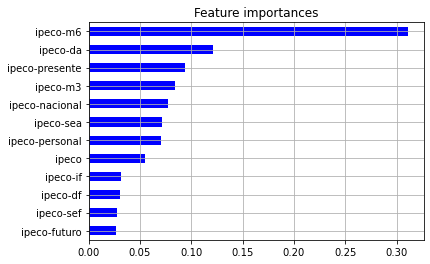

X_train shape: (210, 6) || X_test shape: (1, 6) || y_train shape: (210,)
['ipeco-sea' 'ipeco-nacional' 'ipeco-m3' 'ipeco-presente' 'ipeco-da'
 'ipeco-m6']


In [27]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [28]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:09:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.4135,1.8077,1.3663,0.8502


# IPEC

In [29]:
indice = 'IPEC'
X_train, X_test, y_train = gen_X_train(vipec)

X_train shape: (234, 12) || X_test shape: (1, 12) || y_train shape: (234,)


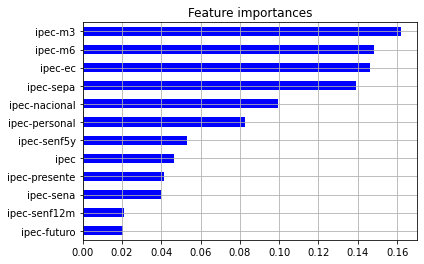

X_train shape: (234, 6) || X_test shape: (1, 6) || y_train shape: (234,)
['ipec-personal' 'ipec-nacional' 'ipec-sepa' 'ipec-ec' 'ipec-m6' 'ipec-m3']


In [30]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [31]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:10:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.4135,1.8077,1.3663,0.8502
IPEC,4.7781,1.9267,1.4461,0.8165


# ICE

In [32]:
indice = 'ICE'
X_train, X_test, y_train = gen_X_train(vice)

X_train shape: (199, 16) || X_test shape: (1, 16) || y_train shape: (199,)


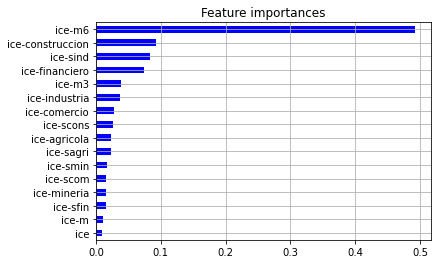

X_train shape: (201, 8) || X_test shape: (1, 8) || y_train shape: (201,)
['ice-scons' 'ice-comercio' 'ice-industria' 'ice-m3' 'ice-financiero'
 'ice-sind' 'ice-construccion' 'ice-m6']


In [33]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [34]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:10:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.4135,1.8077,1.3663,0.8502
IPEC,4.7781,1.9267,1.4461,0.8165
ICE,3.9523,1.7914,1.2297,0.8566


# IMCE

In [35]:
indice = 'IMCE'
X_train, X_test, y_train = gen_X_train(vimce)

X_train shape: (214, 12) || X_test shape: (1, 12) || y_train shape: (214,)


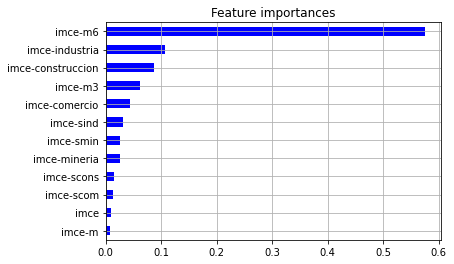

X_train shape: (214, 6) || X_test shape: (1, 6) || y_train shape: (214,)
['imce-sind' 'imce-comercio' 'imce-m3' 'imce-construccion'
 'imce-industria' 'imce-m6']


In [36]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [37]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:10:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.4135,1.8077,1.3663,0.8502
IPEC,4.7781,1.9267,1.4461,0.8165
ICE,3.9523,1.7914,1.2297,0.8566
IMCE,4.1311,1.3538,0.9553,0.9169


# Confianza de los consumidores

In [38]:
indice = 'Consumidores'
X_train, X_test, y_train = gen_X_train(vconsumidores)

X_train shape: (210, 24) || X_test shape: (1, 24) || y_train shape: (210,)


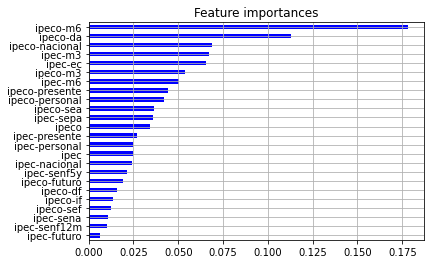

X_train shape: (210, 12) || X_test shape: (1, 12) || y_train shape: (210,)
['ipeco' 'ipec-sepa' 'ipeco-sea' 'ipeco-personal' 'ipeco-presente'
 'ipec-m6' 'ipeco-m3' 'ipec-ec' 'ipec-m3' 'ipeco-nacional' 'ipeco-da'
 'ipeco-m6']


In [39]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [40]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:10:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.4135,1.8077,1.3663,0.8502
IPEC,4.7781,1.9267,1.4461,0.8165
ICE,3.9523,1.7914,1.2297,0.8566
IMCE,4.1311,1.3538,0.9553,0.9169
Consumidores,5.2298,1.7950,1.3327,0.8523


# Confianza empresarial

In [41]:
indice = 'Empresarios'
X_train, X_test, y_train = gen_X_train(vempresarios)

X_train shape: (199, 28) || X_test shape: (1, 28) || y_train shape: (199,)


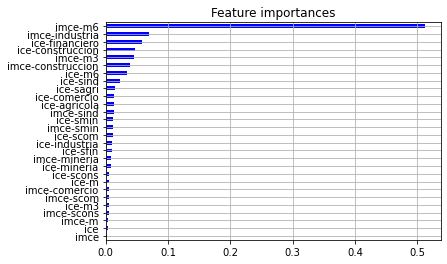

X_train shape: (199, 14) || X_test shape: (1, 14) || y_train shape: (199,)
['imce-smin' 'ice-smin' 'imce-sind' 'ice-agricola' 'ice-comercio'
 'ice-sagri' 'ice-sind' 'ice-m6' 'imce-construccion' 'imce-m3'
 'ice-construccion' 'ice-financiero' 'imce-industria' 'imce-m6']


In [42]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [43]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:10:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 300}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.4135,1.8077,1.3663,0.8502
IPEC,4.7781,1.9267,1.4461,0.8165
ICE,3.9523,1.7914,1.2297,0.8566
IMCE,4.1311,1.3538,0.9553,0.9169
Consumidores,5.2298,1.7950,1.3327,0.8523
Empresarios,3.9939,0.2799,0.1828,0.9965


# Todos los índices

In [44]:
indice = 'Todos'
X_train, X_test, y_train = gen_X_train(X_train0.columns)

X_train shape: (199, 52) || X_test shape: (1, 52) || y_train shape: (199,)


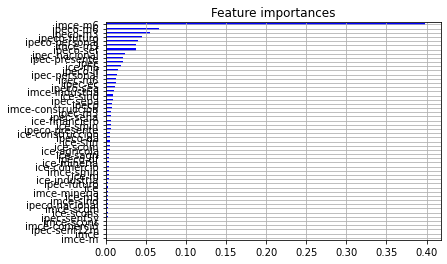

X_train shape: (201, 26) || X_test shape: (1, 26) || y_train shape: (201,)
['ipeco-presente' 'ice-smin' 'ice-financiero' 'ipec-sena' 'ipec-m3'
 'imce-construccion' 'ipeco' 'ipec-sepa' 'ice-sind' 'imce-industria'
 'ipeco-sea' 'ipec-ec' 'ipec-m6' 'ipec-personal' 'ipeco-if' 'ice-m6'
 'ipec' 'ipec-presente' 'ipec-nacional' 'ipeco-sef' 'imce-m3'
 'ipeco-personal' 'ipeco-futuro' 'ipeco-m3' 'ipeco-m6' 'imce-m6']


In [45]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [46]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:10:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.4135,1.8077,1.3663,0.8502
IPEC,4.7781,1.9267,1.4461,0.8165
ICE,3.9523,1.7914,1.2297,0.8566
IMCE,4.1311,1.3538,0.9553,0.9169
Consumidores,5.2298,1.7950,1.3327,0.8523
Empresarios,3.9939,0.2799,0.1828,0.9965
Todos,3.7655,0.6531,0.4953,0.9809


# Evaluación según resultados en CV y train set

In [47]:
samples

,rows,cols
IPECO,210,6
IPEC,234,6
ICE,201,8
IMCE,214,6
Consumidores,210,12
Empresarios,199,14
Todos,201,26


In [48]:
results['Ratio'] = (results['CV_RMSE'] / results['RMSE']).round(2)
print('Best models:')
print(results[['CV_RMSE', 'RMSE', 'MAE', 'Ratio']].idxmin(), '\n')
print('Best R2:')
print(results[['R2']].idxmax(), '\n')
results.round(2)

Best models:
CV_RMSE          Todos
RMSE       Empresarios
MAE        Empresarios
Ratio              ICE
dtype: object 

Best R2:
R2    Empresarios
dtype: object 



,CV_RMSE,RMSE,MAE,R2,Ratio
IPECO,5.41,1.81,1.37,0.85,2.99
IPEC,4.78,1.93,1.45,0.82,2.48
ICE,3.95,1.79,1.23,0.86,2.21
IMCE,4.13,1.35,0.96,0.92,3.05
Consumidores,5.23,1.80,1.33,0.85,2.91
Empresarios,3.99,0.28,0.18,1.00,14.27
Todos,3.77,0.65,0.50,0.98,5.77


In [49]:
predicciones = predicciones.reset_index()
predicciones.columns = ['percepcion', 'prediccion']
predicciones.round(2)

,percepcion,prediccion
0,IPECO,5.60
1,IPEC,6.02
2,ICE,6.56
3,IMCE,8.10
4,Consumidores,8.20
5,Empresarios,6.12
6,Todos,8.88


In [50]:
print('Mayor predicción:')
print(predicciones['prediccion'].idxmax(), '\n')

print('Menor predicción:')
print(predicciones['prediccion'].idxmin(), '\n')

Mayor predicción:
6 

Menor predicción:
0 



In [51]:
print('Predicción de la encuesta de expectativas económicas:')
pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', index_col='Fecha')['IMACEC un mes atrás'].tail(1)

Predicción de la encuesta de expectativas económicas:


Fecha
01-03-2022    7.5
Name: IMACEC un mes atrás, dtype: float64

In [52]:
# ACTUALIZAR nombre de documento
predicciones.to_csv('pred_2022_03.csv', index=False)